<a href="https://colab.research.google.com/github/DmitryIo/translation/blob/master/translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('translating.txt', sep='\t', header=None)

In [0]:
data.to_csv('/content/translation.csv', header=['text', 'target'], index_label=False)

In [0]:

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
!python -m spacy download xx
!python -m spacy download en

In [0]:
spacy_ru = spacy.load('xx')
spacy_en = spacy.load('en')

In [0]:
def tokenize_ru(text):
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [0]:
import pandas as pd
dot = pd.read_csv('/content/translation.csv')
dot.to_csv('/content/dot.csv', header=['src', 'trg'], index_label=False)


In [0]:
from torchtext import data
fields = [('index', None), ('src', SRC), ('trg', TRG)]
dataset = data.TabularDataset(path="/content/dot.csv", format="CSV", fields=fields, skip_header=True)

In [0]:
train_data, valid_data = dataset.split()

In [37]:
vars(train_data.examples[0])

{'src': ['there',
  'is',
  'a',
  '24-hour',
  'front',
  'desk',
  'at',
  'the',
  'property',
  '.'],
 'trg': ['стойка', 'регистрации', 'открыта', 'круглосуточно', '.']}

In [42]:
vars(valid_data.examples[3])

{'src': ['sikeston',
  'factory',
  'outlet',
  'stores',
  'are',
  'less',
  'than',
  '2',
  'minutes',
  '’',
  'drive',
  'away',
  '.'],
 'trg': ['до',
  'магазинов',
  'центра',
  'распродаж',
  'sikeston',
  'factory',
  'можно',
  'доехать',
  'меньше',
  'чем',
  'за',
  '2',
  'минуты',
  '.']}

In [0]:
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [0]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data),
    sort_key=lambda x: data.interleave_keys(len(x.src), len(x.trg)), 
    batch_size = BATCH_SIZE, 
    device = device)

In [0]:
  class Encoder(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell


In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
              #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(25505, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(36251, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=36251, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [24]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 41,762,715 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

          
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Time: 3m 56s
	Train Loss: 6.354 | Train PPL: 574.871
	 Val. Loss: 6.073 |  Val. PPL: 434.139
Epoch: 02 | Time: 3m 56s
	Train Loss: 5.479 | Train PPL: 239.629
	 Val. Loss: 6.295 |  Val. PPL: 541.970
Epoch: 03 | Time: 3m 55s
	Train Loss: 4.915 | Train PPL: 136.354
	 Val. Loss: 6.538 |  Val. PPL: 691.018
Epoch: 04 | Time: 3m 56s
	Train Loss: 4.555 | Train PPL:  95.126
	 Val. Loss: 6.582 |  Val. PPL: 722.189
Epoch: 05 | Time: 3m 54s
	Train Loss: 4.215 | Train PPL:  67.694
	 Val. Loss: 6.139 |  Val. PPL: 463.789
Epoch: 06 | Time: 3m 55s
	Train Loss: 3.973 | Train PPL:  53.155
	 Val. Loss: 6.086 |  Val. PPL: 439.572
Epoch: 07 | Time: 3m 53s
	Train Loss: 3.797 | Train PPL:  44.586
	 Val. Loss: 6.000 |  Val. PPL: 403.271
Epoch: 08 | Time: 3m 54s
	Train Loss: 3.675 | Train PPL:  39.445
	 Val. Loss: 5.678 |  Val. PPL: 292.305
Epoch: 09 | Time: 3m 55s
	Train Loss: 3.484 | Train PPL:  32.576
	 Val. Loss: 5.786 |  Val. PPL: 325.701
Epoch: 10 | Time: 3m 53s
	Train Loss: 3.385 | Train PPL

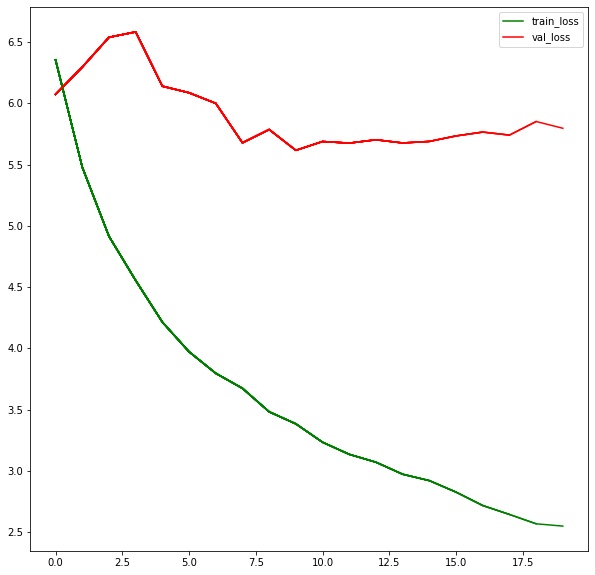

In [30]:
N_EPOCHS = 20
CLIP = 1
import matplotlib.pyplot as plt
best_valid_loss = float('inf')
plt.figure(figsize=(10,10))
train_loss_mass = []
epocher = []
val_loss_mass =[]
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epocher.append(epoch)
    train_loss_mass.append(train_loss)
    val_loss_mass.append(valid_loss)

    plt.plot(epocher, train_loss_mass,  color='green', label='train_loss')
    plt.plot(epocher, val_loss_mass, color='red', label='val_loss')
    if epoch == 0:
      plt.legend()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/banana projects/translator_baseline/tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
from torchtext.data import RawField
from torchtext.data import Batch
import torchtext
def predict(model, sentence, SRC, TRG):
  model.eval()
  d = {'src': sentence, 'trg': sentence}
  df = pd.DataFrame(data=d, index=range(1))
  df.to_csv('df.csv', index_label=False)
  fields = [(None, None), ('src', SRC), ('trg', TRG)]
  prediction = torchtext.data.TabularDataset.splits(path='/content/.', train = 'df.csv', format='csv', fields=fields, skip_header = True)[0]
  BATCH_SIZE = 1
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  predict_generator = BucketIterator(
    prediction,
    sort_key=lambda x: data.interleave_keys(len(x.src), len(x.trg)), 
    batch_size = BATCH_SIZE, 
    device = device)
  with torch.no_grad():
    for i, batch in enumerate(predict_generator):
      src = batch.src
      trg = batch.trg
      output = model(src, trg, 0)
      output_dim = output.shape[-1]
            
      output = output[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)
  listik = []
  for i in torch.argmax(output, dim=1):
    if TRG.vocab.itos[i] == '<eos>':
      break
    listik.append(TRG.vocab.itos[i])
  return ' '.join(listik)


In [34]:
for i in range(10):
  att = pd.read_csv('dot.csv').sample(1)['src'].values[0]
  output = predict(model, att, SRC, TRG)
  print(f'Sentence: {att} |\nTranslation: {output}')

Sentence: The property boasts views of the Yatsugadake and Chichibu Mountains, the Southern Alps and Mount Fuji. |
Translation: из окон открывается вид на горы , стартовую чичибу южные лес .
Sentence: Russian National Public Library for Science and Technology is 4.2 km from Apartment On Gorskiy 63/1, while Novosibirsk Opera and Ballet Theatre is 4.3 km away. |
Translation: расстояние от отеля типа « постель и завтрак » bahar до пристаней для яхт эдже - сарай , фетхие составляет 2,6 км , а до хоккейной аэропорта — —
Sentence: It has a washing machine, ironing facilities and 3 bathrooms. |
Translation: в распоряжении гостей стиральная машина , сушильная машина и стиральная машина .
Sentence: Rooms have simple modern furnishings and resin floors. |
Translation: номера оформлены в строгом стиле и обставлены деревянной мебелью .
Sentence: Other facilities offered include meeting facilities and luggage storage. |
Translation: в распоряжении гостей помещения для проведения конференций , камер